<a href="https://colab.research.google.com/github/Mak7k/AndrushkevichMV_KR/blob/main/%D0%98%D0%A1%D0%A2_7_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Практика 7-8

Выполнил студент группы ИНМО-01-25 Андрушкевич М.В.

Балансировка классов и классификация

In [5]:
# Блок 0: Установка необходимых библиотек
!pip install ucimlrepo umap-learn trimap pacmap imbalanced-learn

In [6]:
# Блок 1: Импорт библиотек
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
from sklearn.manifold import TSNE
import umap.umap_ as umap
import trimap
import pacmap
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from imblearn.over_sampling import SMOTE, BorderlineSMOTE
from ucimlrepo import fetch_ucirepo

In [7]:
# Блок 2: Загрузка датасета Post-Operative Patient
post_operative = fetch_ucirepo(id=82)

X = post_operative.data.features
y = post_operative.data.targets

print("Форма данных X:", X.shape)
print("Форма данных y:", y.shape)
print("\nПервые 5 строк X:")
print(X.head())
print("\nЦелевая переменная:")
print(y.iloc[:, 0].value_counts())

Форма данных X: (90, 8)
Форма данных y: (90, 1)

Первые 5 строк X:
  L-CORE L-SURF       L-O2  L-BP SURF-STBL CORE-STBL     BP-STBL  COMFORT
0    mid    low  excellent   mid    stable    stable      stable     15.0
1    mid   high  excellent  high    stable    stable      stable     10.0
2   high    low  excellent  high    stable    stable  mod-stable     10.0
3    mid    low       good  high    stable  unstable  mod-stable     15.0
4    mid    mid  excellent  high    stable    stable      stable     10.0

Целевая переменная:
ADM-DECS
A     63
S     24
I      2
A      1
Name: count, dtype: int64


In [8]:
# Блок 3: Предобработка данных
print("Пропущенные значения в X:")
print(X.isnull().sum())

# Заполнение пропусков
for col in X.columns:
    if X[col].isnull().sum() > 0:
        X[col] = X[col].fillna(X[col].mode()[0])

# Очистка целевой переменной - убираем пробелы
y_cleaned = y.iloc[:, 0].str.strip()
print("\nЦелевая переменная после очистки:")
print(y_cleaned.value_counts())

# Кодируем категориальные признаки
categorical_columns = X.select_dtypes(include=['object']).columns
label_encoders = {}
for col in categorical_columns:
    le = LabelEncoder()
    X[col] = le.fit_transform(X[col].astype(str))
    label_encoders[col] = le

# Кодируем целевую переменную
le_target = LabelEncoder()
y_encoded = le_target.fit_transform(y_cleaned)
print("Закодированные метки классов:", le_target.classes_)

# Проверяем распределение классов
unique, counts = np.unique(y_encoded, return_counts=True)
print("Распределение классов:", dict(zip(le_target.classes_, counts)))

# Масштабирование данных
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Пропущенные значения в X:
L-CORE       0
L-SURF       0
L-O2         0
L-BP         0
SURF-STBL    0
CORE-STBL    0
BP-STBL      0
COMFORT      3
dtype: int64

Целевая переменная после очистки:
ADM-DECS
A    64
S    24
I     2
Name: count, dtype: int64
Закодированные метки классов: ['A' 'I' 'S']
Распределение классов: {'A': np.int64(64), 'I': np.int64(2), 'S': np.int64(24)}


In [9]:
# Блок 4: Кастомное разделение на train/test
def custom_train_test_split(X, y, test_size=0.3, random_state=42):
    """
    Кастомное разделение, которое обрабатывает классы с малым количеством примеров
    """
    rng = np.random.RandomState(random_state)
    classes = np.unique(y)
    train_indices = []
    test_indices = []

    for class_label in classes:
        class_indices = np.where(y == class_label)[0]
        n_samples = len(class_indices)

        if n_samples == 1:
            # Для классов с 1 примером - всегда в train
            train_indices.extend(class_indices)
        else:
            # Для классов с >1 примером - обычное разделение
            n_test = max(1, int(n_samples * test_size))  # минимум 1 в test
            n_test = min(n_test, n_samples - 1)  # минимум 1 в train

            shuffled_indices = rng.permutation(class_indices)
            test_indices.extend(shuffled_indices[:n_test])
            train_indices.extend(shuffled_indices[n_test:])

    return X[train_indices], X[test_indices], y[train_indices], y[test_indices]

# Разделение данных
X_train, X_test, y_train, y_test = custom_train_test_split(X_scaled, y_encoded, test_size=0.3, random_state=42)

print(f"\nРазмер train: {X_train.shape}, test: {X_test.shape}")
print("Распределение в train:", dict(zip(le_target.classes_, np.bincount(y_train))))
print("Распределение в test:", dict(zip(le_target.classes_, np.bincount(y_test))))



Размер train: (63, 8), test: (27, 8)
Распределение в train: {'A': np.int64(45), 'I': np.int64(1), 'S': np.int64(17)}
Распределение в test: {'A': np.int64(19), 'I': np.int64(1), 'S': np.int64(7)}


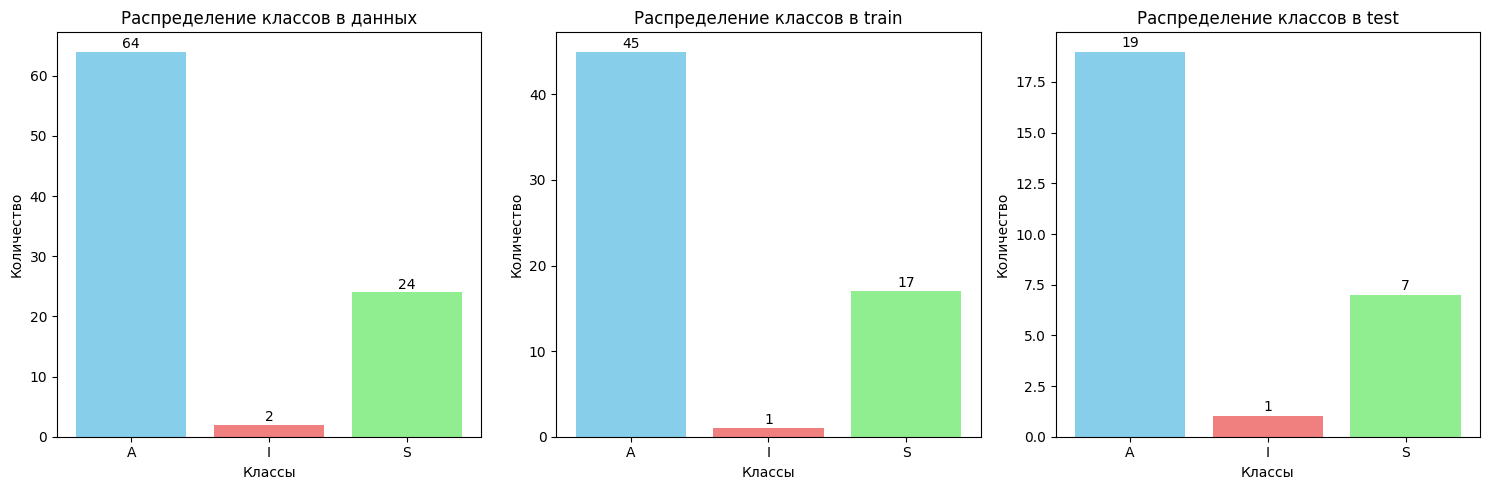

In [10]:
# Блок 5: Визуализация исходного распределения классов
plt.figure(figsize=(15, 5))

# Функция для безопасного построения графиков распределения
def safe_bar_plot(classes, counts, title, ax):
    """Безопасное построение bar plot с проверкой размеров"""
    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold', 'lightpink']
    if len(classes) == len(counts):
        bars = ax.bar(classes, counts, color=colors[:len(classes)])
        ax.set_title(title)
        ax.set_xlabel('Классы')
        ax.set_ylabel('Количество')
        for bar, count in zip(bars, counts):
            ax.text(bar.get_x() + bar.get_width()/2, count + 0.1, str(count),
                   ha='center', va='bottom')
    else:
        ax.text(0.5, 0.5, f'Ошибка: {len(classes)} классов vs {len(counts)} значений',
               ha='center', va='center', transform=ax.transAxes)
        ax.set_title(title)

# Распределение в полном наборе данных
ax1 = plt.subplot(1, 3, 1)
unique_full, counts_full = np.unique(y_encoded, return_counts=True)
safe_bar_plot(le_target.classes_, counts_full, 'Распределение классов в данных', ax1)

# Распределение в train
ax2 = plt.subplot(1, 3, 2)
unique_train, counts_train = np.unique(y_train, return_counts=True)
# Создаем массив counts для всех возможных классов
train_counts_complete = [counts_train[unique_train == i][0] if i in unique_train else 0 for i in range(len(le_target.classes_))]
safe_bar_plot(le_target.classes_, train_counts_complete, 'Распределение классов в train', ax2)

# Распределение в test
ax3 = plt.subplot(1, 3, 3)
unique_test, counts_test = np.unique(y_test, return_counts=True)
# Создаем массив counts для всех возможных классов
test_counts_complete = [counts_test[unique_test == i][0] if i in unique_test else 0 for i in range(len(le_target.classes_))]
safe_bar_plot(le_target.classes_, test_counts_complete, 'Распределение классов в test', ax3)

plt.tight_layout()
plt.show()

ПРИМЕНЕНИЕ АЛГОРИТМОВ БАЛАНСИРОВКИ
SMOTE не применим: Expected n_neighbors <= n_samples_fit, but n_neighbors = 6, n_samples_fit = 1, n_samples = 1
Borderline-SMOTE1: (63, 8) -> (91, 8)
Borderline-SMOTE2: (63, 8) -> (91, 8)


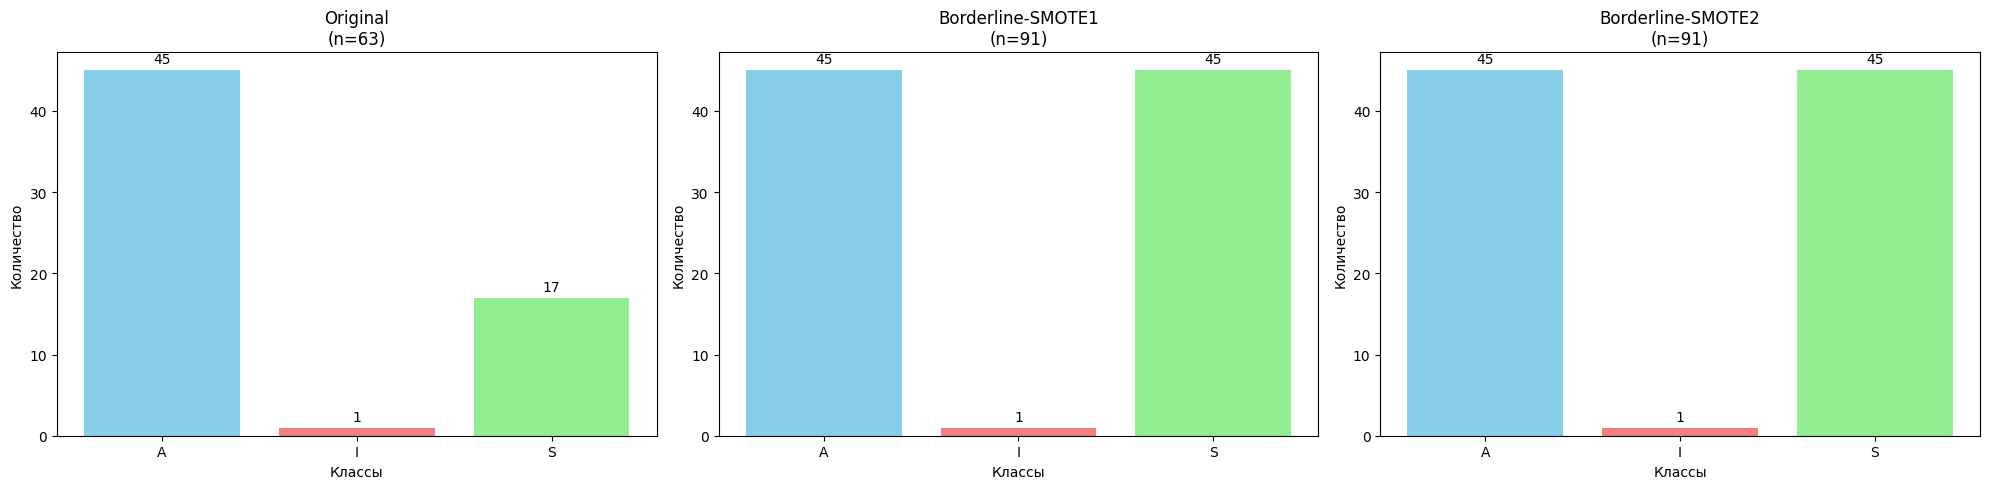

In [11]:
# Блок 6: Применение алгоритмов балансировки
print("=" * 60)
print("ПРИМЕНЕНИЕ АЛГОРИТМОВ БАЛАНСИРОВКИ")
print("=" * 60)

# Создаем словарь для хранения сбалансированных данных
balanced_datasets = {'Original': (X_train, y_train)}

# SMOTE
try:
    smote = SMOTE(random_state=42)
    X_smote, y_smote = smote.fit_resample(X_train, y_train)
    balanced_datasets['SMOTE'] = (X_smote, y_smote)
    print(f"SMOTE: {X_train.shape} -> {X_smote.shape}")
except Exception as e:
    print(f"SMOTE не применим: {e}")

# Borderline-SMOTE1
try:
    borderline1 = BorderlineSMOTE(kind='borderline-1', random_state=42)
    X_borderline1, y_borderline1 = borderline1.fit_resample(X_train, y_train)
    balanced_datasets['Borderline-SMOTE1'] = (X_borderline1, y_borderline1)
    print(f"Borderline-SMOTE1: {X_train.shape} -> {X_borderline1.shape}")
except Exception as e:
    print(f"Borderline-SMOTE1 не применим: {e}")

# Borderline-SMOTE2
try:
    borderline2 = BorderlineSMOTE(kind='borderline-2', random_state=42)
    X_borderline2, y_borderline2 = borderline2.fit_resample(X_train, y_train)
    balanced_datasets['Borderline-SMOTE2'] = (X_borderline2, y_borderline2)
    print(f"Borderline-SMOTE2: {X_train.shape} -> {X_borderline2.shape}")
except Exception as e:
    print(f"Borderline-SMOTE2 не применим: {e}")

# Визуализация результатов балансировки
plt.figure(figsize=(20, 5))

methods = list(balanced_datasets.keys())

for i, method in enumerate(methods):
    plt.subplot(1, len(methods), i+1)
    X_bal, y_bal = balanced_datasets[method]
    unique, counts = np.unique(y_bal, return_counts=True)

    # Создаем полный массив counts для всех классов
    complete_counts = [counts[unique == i][0] if i in unique else 0 for i in range(len(le_target.classes_))]

    colors = ['skyblue', 'lightcoral', 'lightgreen', 'gold'][:len(le_target.classes_)]
    bars = plt.bar(range(len(le_target.classes_)), complete_counts, color=colors, tick_label=le_target.classes_)
    plt.title(f'{method}\n(n={len(y_bal)})')
    plt.xlabel('Классы')
    plt.ylabel('Количество')
    for j, v in enumerate(complete_counts):
        plt.text(j, v + 0.5, str(v), ha='center', va='bottom')

plt.tight_layout()
plt.show()

In [12]:
# Блок 7: Обучение классификаторов и оценка
print("=" * 60)
print("ОБУЧЕНИЕ И ОЦЕНКА КЛАССИФИКАТОРОВ")
print("=" * 60)

classifiers = {
    'SVM': SVC(random_state=42),
    'k-NN': KNeighborsClassifier(n_neighbors=3),
    'Random Forest': RandomForestClassifier(random_state=42, n_estimators=100)
}

results = {}

# Функция для оценки модели
def evaluate_model(model, X_test, y_test, method_name, classifier_name):
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average='weighted')

    print(f"{method_name} + {classifier_name}:")
    print(f"  Accuracy: {accuracy:.4f}")
    print(f"  F1-score: {f1:.4f}")
    print(classification_report(y_test, y_pred, target_names=le_target.classes_))

    return accuracy, f1, y_pred

# Обучение на всех методах балансировки
for method, (X_bal, y_bal) in balanced_datasets.items():
    print("\n" + "-" * 40)
    print(f"РЕЗУЛЬТАТЫ ДЛЯ {method}")
    print("-" * 40)

    results[method] = {}
    for name, clf in classifiers.items():
        # Создаем новый экземпляр классификатора
        if name == 'SVM':
            new_clf = SVC(random_state=42)
        elif name == 'k-NN':
            new_clf = KNeighborsClassifier(n_neighbors=3)
        else:  # Random Forest
            new_clf = RandomForestClassifier(random_state=42, n_estimators=100)

        try:
            new_clf.fit(X_bal, y_bal)
            accuracy, f1, y_pred = evaluate_model(new_clf, X_test, y_test, method, name)
            results[method][name] = {
                'accuracy': accuracy,
                'f1_score': f1,
                'predictions': y_pred,
                'model': new_clf
            }
        except Exception as e:
            print(f"Ошибка при обучении {method} + {name}: {e}")

ОБУЧЕНИЕ И ОЦЕНКА КЛАССИФИКАТОРОВ

----------------------------------------
РЕЗУЛЬТАТЫ ДЛЯ Original
----------------------------------------
Original + SVM:
  Accuracy: 0.7037
  F1-score: 0.5813
              precision    recall  f1-score   support

           A       0.70      1.00      0.83        19
           I       0.00      0.00      0.00         1
           S       0.00      0.00      0.00         7

    accuracy                           0.70        27
   macro avg       0.23      0.33      0.28        27
weighted avg       0.50      0.70      0.58        27

Original + k-NN:
  Accuracy: 0.6296
  F1-score: 0.5438
              precision    recall  f1-score   support

           A       0.68      0.89      0.77        19
           I       0.00      0.00      0.00         1
           S       0.00      0.00      0.00         7

    accuracy                           0.63        27
   macro avg       0.23      0.30      0.26        27
weighted avg       0.48      0.63      0.54

СРАВНЕНИЕ РЕЗУЛЬТАТОВ

Сводная таблица результатов:
Метод балансировки Классификатор  Accuracy  F1-Score
          Original           SVM  0.703704  0.581320
          Original          k-NN  0.629630  0.543771
          Original Random Forest  0.555556  0.502646
 Borderline-SMOTE1           SVM  0.333333  0.361905
 Borderline-SMOTE1          k-NN  0.370370  0.401235
 Borderline-SMOTE1 Random Forest  0.592593  0.523686
 Borderline-SMOTE2           SVM  0.407407  0.418418
 Borderline-SMOTE2          k-NN  0.481481  0.491043
 Borderline-SMOTE2 Random Forest  0.555556  0.502646


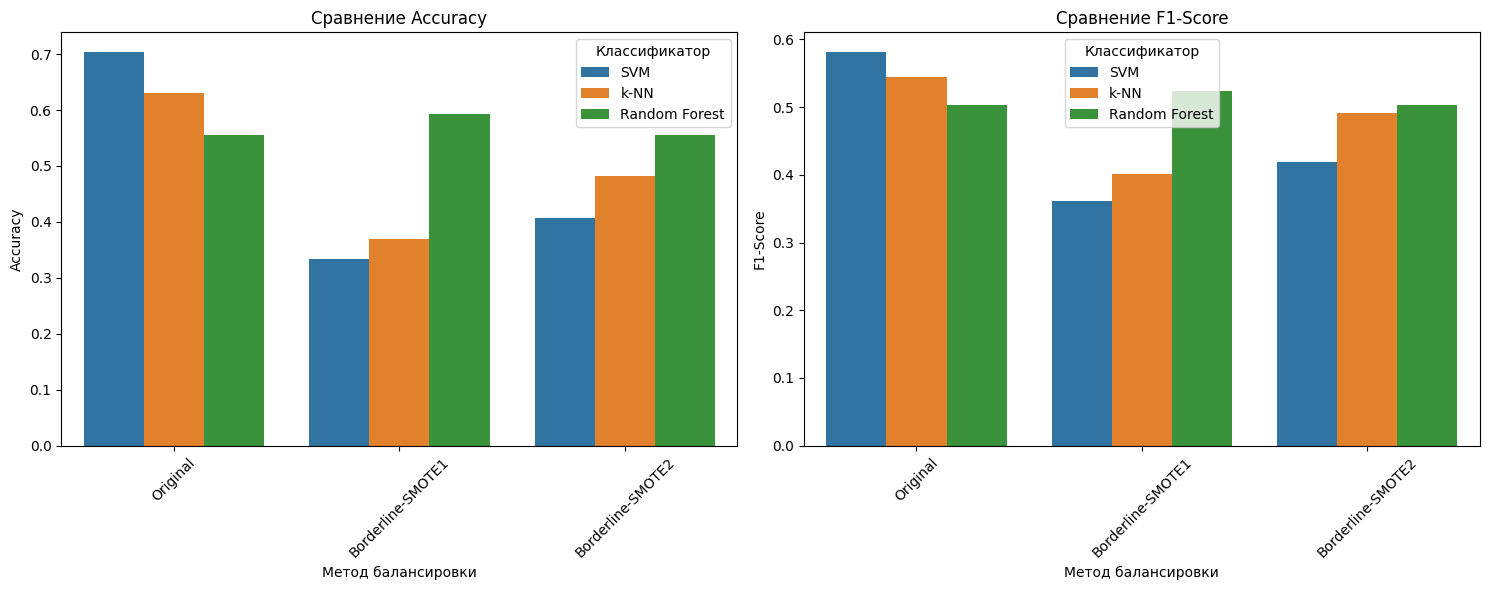


🎯 ЛУЧШАЯ КОМБИНАЦИЯ ПО ACCURACY:
  Метод: Original
  Классификатор: SVM
  Accuracy: 0.7037

🎯 ЛУЧШАЯ КОМБИНАЦИЯ ПО F1-SCORE:
  Метод: Original
  Классификатор: SVM
  F1-Score: 0.5813


In [13]:

# Блок 8: Сравнение результатов
print("=" * 60)
print("СРАВНЕНИЕ РЕЗУЛЬТАТОВ")
print("=" * 60)

# Создаем таблицу для сравнения
comparison_data = []
for method, method_results in results.items():
    for classifier, metrics in method_results.items():
        comparison_data.append({
            'Метод балансировки': method,
            'Классификатор': classifier,
            'Accuracy': metrics['accuracy'],
            'F1-Score': metrics['f1_score']
        })

comparison_df = pd.DataFrame(comparison_data)
print("\nСводная таблица результатов:")
print(comparison_df.to_string(index=False))

# Визуализация сравнения
if len(comparison_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

    # Accuracy
    sns.barplot(data=comparison_df, x='Метод балансировки', y='Accuracy', hue='Классификатор', ax=ax1)
    ax1.set_title('Сравнение Accuracy')
    ax1.tick_params(axis='x', rotation=45)

    # F1-Score
    sns.barplot(data=comparison_df, x='Метод балансировки', y='F1-Score', hue='Классификатор', ax=ax2)
    ax2.set_title('Сравнение F1-Score')
    ax2.tick_params(axis='x', rotation=45)

    plt.tight_layout()
    plt.show()

    # Находим лучшую комбинацию
    if not comparison_df.empty:
        best_accuracy = comparison_df.loc[comparison_df['Accuracy'].idxmax()]
        best_f1 = comparison_df.loc[comparison_df['F1-Score'].idxmax()]

        print(f"\n🎯 ЛУЧШАЯ КОМБИНАЦИЯ ПО ACCURACY:")
        print(f"  Метод: {best_accuracy['Метод балансировки']}")
        print(f"  Классификатор: {best_accuracy['Классификатор']}")
        print(f"  Accuracy: {best_accuracy['Accuracy']:.4f}")

        print(f"\n🎯 ЛУЧШАЯ КОМБИНАЦИЯ ПО F1-SCORE:")
        print(f"  Метод: {best_f1['Метод балансировки']}")
        print(f"  Классификатор: {best_f1['Классификатор']}")
        print(f"  F1-Score: {best_f1['F1-Score']:.4f}")

        best_method = best_accuracy['Метод балансировки']
        best_classifier = best_accuracy['Классификатор']
        best_model = results[best_method][best_classifier]['model']
        y_pred_best = best_model.predict(X_test)
    else:
        print("Нет результатов для сравнения")
        best_method = None
else:
    print("Нет результатов для сравнения")
    best_method = None

In [15]:
# Блок 9: Функции для визуализации
def plot_embedding(embedding, labels, title, class_names=None):
    """Функция для отрисовки 2D вложения"""
    plt.figure(figsize=(8, 6))
    if class_names is None:
        class_names = [f'Class {i}' for i in np.unique(labels)]

    for class_idx, class_name in enumerate(class_names):
        mask = labels == class_idx
        if np.sum(mask) > 0:  # Проверяем, что есть точки для этого класса
            plt.scatter(embedding[mask, 0], embedding[mask, 1],
                       label=class_name, alpha=0.7, s=50)

    plt.title(title)
    plt.xlabel('Component 1')
    plt.ylabel('Component 2')
    plt.legend()
    plt.show()

def apply_tsne(data, n_components=2, **params):
    """Применение t-SNE"""
    tsne = TSNE(n_components=n_components, random_state=42, **params)
    return tsne.fit_transform(data)

def apply_umap(data, n_components=2, **params):
    """Применение UMAP"""
    reducer = umap.UMAP(n_components=n_components, random_state=42, **params)
    return reducer.fit_transform(data)

def apply_trimap(data, n_components=2, **params):
    """Применение TriMAP"""
    reducer = trimap.TRIMAP(n_dims=n_components, **params)
    return reducer.fit_transform(data)

def apply_pacmap(data, n_components=2, **params):
    """Применение PaCMAP"""
    reducer = pacmap.PaCMAP(n_components=n_components, **params)
    return reducer.fit_transform(data)


ВИЗУАЛИЗАЦИЯ РАЗБИЕНИЯ НА КЛАССЫ
Визуализация для лучшей комбинации: Original + SVM

--- t-SNE ---


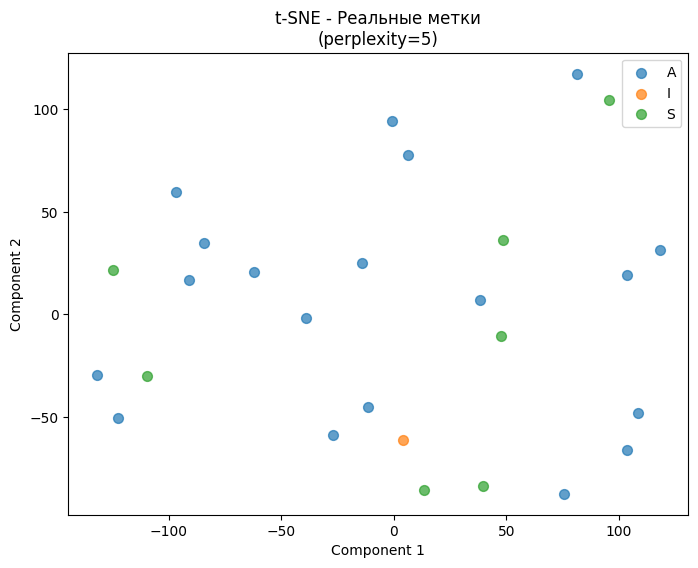

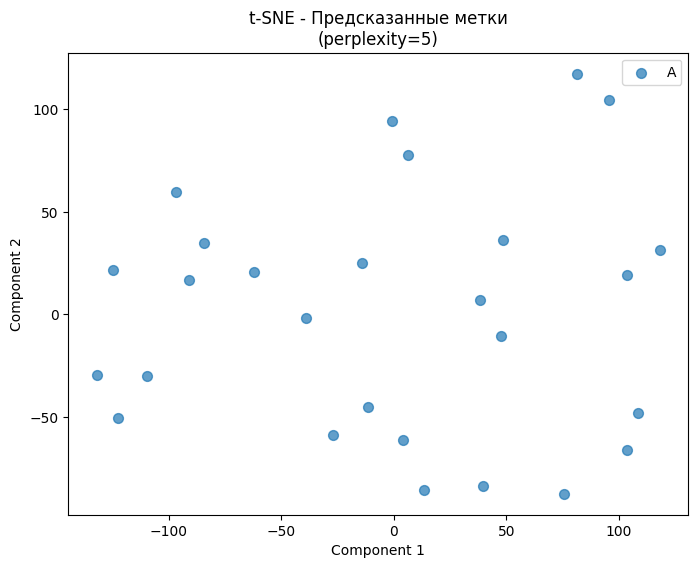

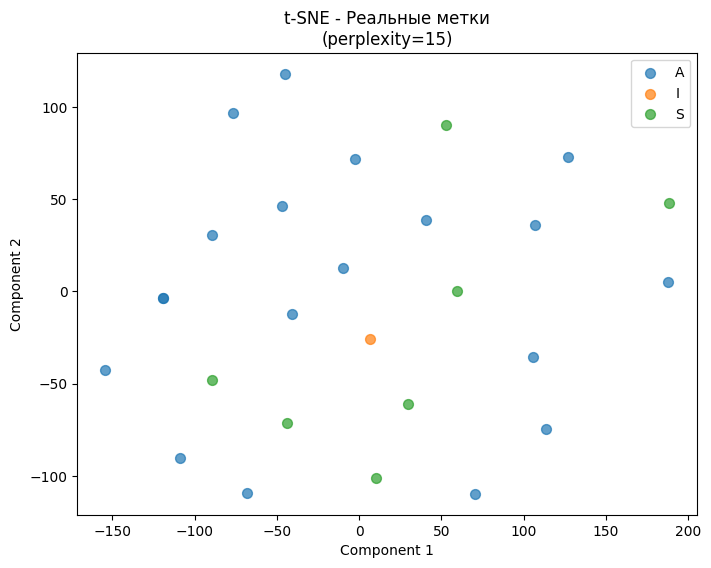

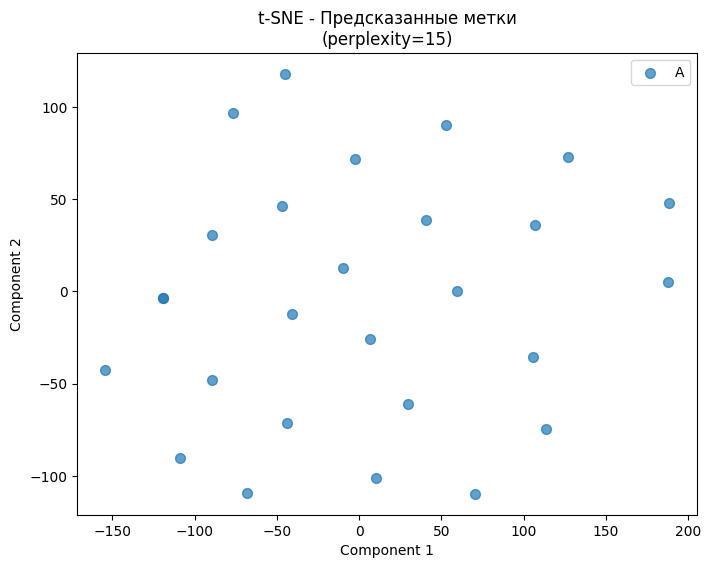

Ошибка при t-SNE с параметрами {'perplexity': 30}: perplexity must be less than n_samples

--- UMAP ---


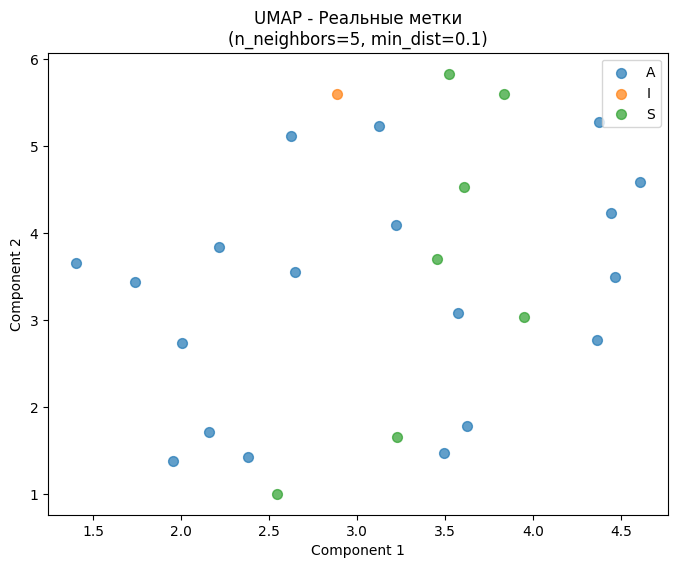

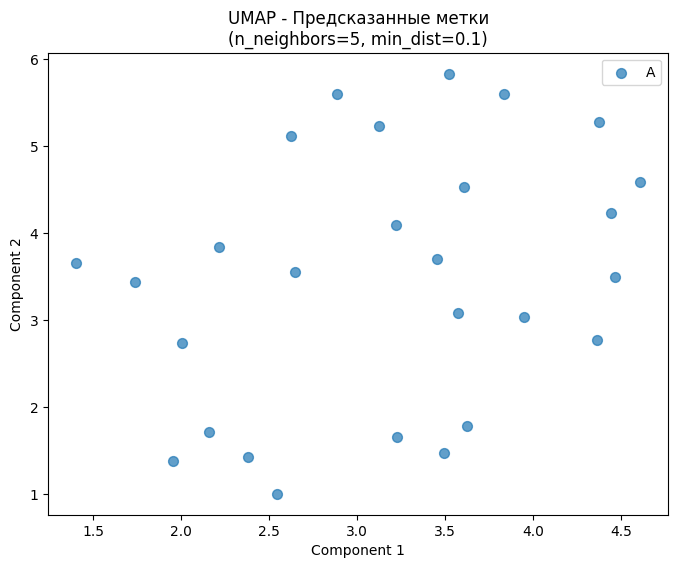

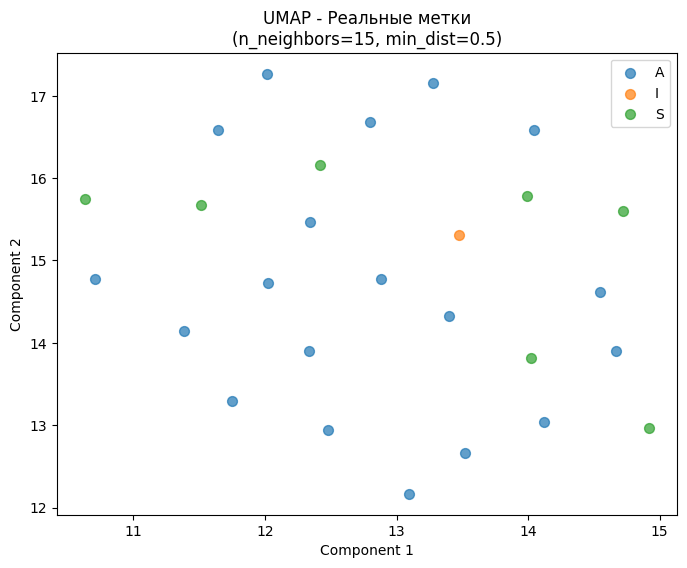

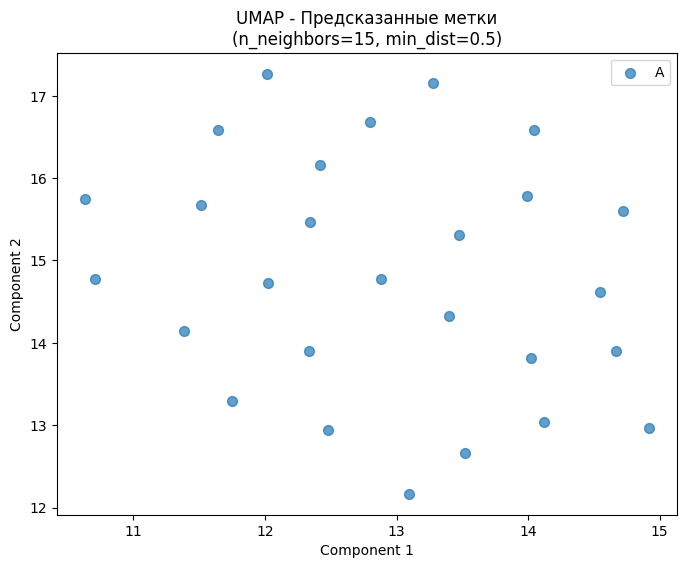

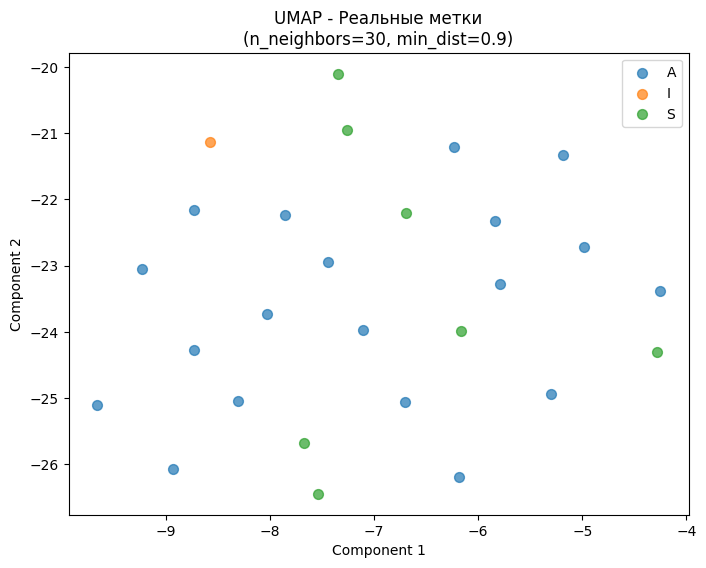

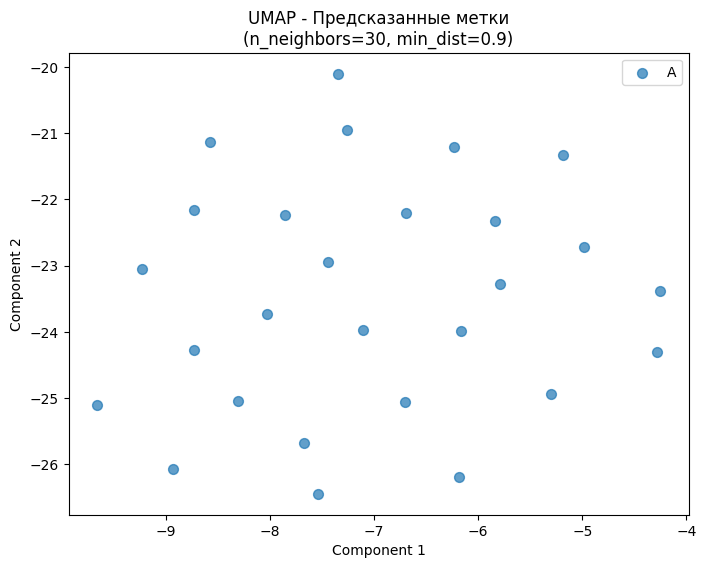

In [16]:
# Блок 10: Визуализация с различными методами
if best_method is not None:
    print("=" * 60)
    print("ВИЗУАЛИЗАЦИЯ РАЗБИЕНИЯ НА КЛАССЫ")
    print("=" * 60)

    print(f"Визуализация для лучшей комбинации: {best_method} + {best_classifier}")

    # Визуализация: реальные метки vs предсказанные метки
    methods_visualization = {
        't-SNE': apply_tsne,
        'UMAP': apply_umap
    }

    # Параметры для каждого метода
    params_dict = {
        't-SNE': [
            {'perplexity': 5},
            {'perplexity': 15},
            {'perplexity': 30}
        ],
        'UMAP': [
            {'n_neighbors': 5, 'min_dist': 0.1},
            {'n_neighbors': 15, 'min_dist': 0.5},
            {'n_neighbors': 30, 'min_dist': 0.9}
        ]
    }

    # Визуализация для каждого метода с разными параметрами
    for method_name, method_func in methods_visualization.items():
        print(f"\n--- {method_name} ---")

        params_list = params_dict.get(method_name, [{}])

        for i, params in enumerate(params_list):
            # Применяем метод снижения размерности
            try:
                embedding = method_func(X_test, **params)

                # Визуализация реальных меток
                param_str = ', '.join([f'{k}={v}' for k, v in params.items()])
                plot_embedding(embedding, y_test,
                             f'{method_name} - Реальные метки\n({param_str})',
                             le_target.classes_)

                # Визуализация предсказанных меток
                plot_embedding(embedding, y_pred_best,
                             f'{method_name} - Предсказанные метки\n({param_str})',
                             le_target.classes_)

            except Exception as e:
                print(f"Ошибка при {method_name} с параметрами {params}: {e}")

АНАЛИЗ МАТРИЦ ОШИБОК


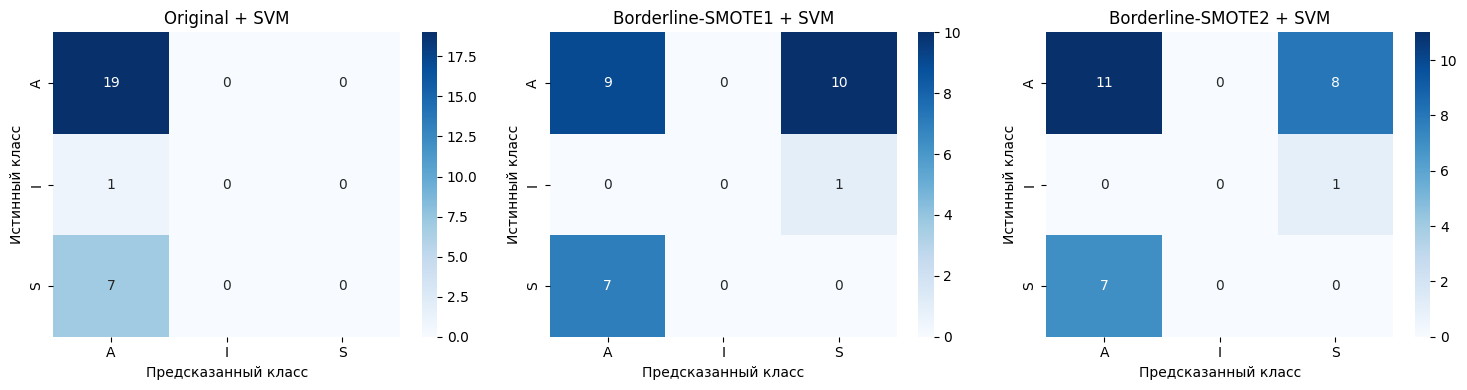

In [17]:
# Блок 11: Анализ матриц ошибок
print("=" * 60)
print("АНАЛИЗ МАТРИЦ ОШИБОК")
print("=" * 60)

if len(results) > 0:
    methods_to_show = list(results.keys())[:min(4, len(results))]
    n_methods = len(methods_to_show)

    fig, axes = plt.subplots(1, n_methods, figsize=(5*n_methods, 4))
    if n_methods == 1:
        axes = [axes]

    for i, method in enumerate(methods_to_show):
        if i >= n_methods:
            break

        # Берем первый классификатор для каждого метода для демонстрации
        classifier_name = list(results[method].keys())[0]
        y_pred = results[method][classifier_name]['predictions']

        cm = confusion_matrix(y_test, y_pred)
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', ax=axes[i],
                    xticklabels=le_target.classes_, yticklabels=le_target.classes_)
        axes[i].set_title(f'{method} + {classifier_name}')
        axes[i].set_xlabel('Предсказанный класс')
        axes[i].set_ylabel('Истинный класс')

    plt.tight_layout()
    plt.show()


In [18]:
# Блок 12: Выводы и гипотезы
print("=" * 60)
print("ВЫВОДЫ И ГИПОТЕЗЫ")
print("=" * 60)

if best_method is not None:
    print("ГИПОТЕЗА О ЛУЧШЕМ АЛГОРИТМЕ БАЛАНСИРОВКИ:")
    print(f"На основе проведенных экспериментов можно предположить, что {best_method} ")
    print("показал наилучшие результаты по следующим причинам:")

    if best_method == 'SMOTE':
        print("- SMOTE эффективно создает синтетические примеры в пространстве признаков")
        print("- Хорошо работает когда миноритарные классы имеют четкие кластеры")
    elif 'Borderline' in best_method:
        print("- Borderline-SMOTE фокусируется на примерах near decision boundary")
        print("- Это особенно полезно когда классы сильно перекрываются")
    else:
        print("- Исходные данные уже имели достаточную информативность")

    print(f"\nПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:")
    print(f"1. Для данного набора данных рекомендую использовать {best_method} + {best_classifier}")
    print(f"2. Достигнутая точность: {best_accuracy['Accuracy']:.4f}")
    print(f"3. F1-Score: {best_f1['F1-Score']:.4f}")

    # Сравнение с исходными данными
    if 'Original' in results:
        original_accuracy = comparison_df[
            (comparison_df['Метод балансировки'] == 'Original') &
            (comparison_df['Классификатор'] == best_classifier)
        ]['Accuracy'].values[0]

        improvement = best_accuracy['Accuracy'] - original_accuracy
        print(f"4. Улучшение по сравнению с исходными данными: {improvement:.4f}")

        if improvement > 0:
            print("   Балансировка данных оказала положительное влияние на качество классификации.")
        else:
            print("   Балансировка данных не улучшила качество классификации для данного набора.")
else:
    print("Не удалось определить лучший метод из-за ошибок в вычислениях.")

print("\nОСОБЕННОСТИ ДАННОГО НАБОРА ДАННЫХ:")
print("- Очень несбалансированные классы")
print("- Наличие класса с всего 1 примером")
print("- Необходимость аккуратной обработки классов с малым количеством примеров")
print("- Проблема с классом 'A ' (с пробелом) была решена очисткой данных")

ВЫВОДЫ И ГИПОТЕЗЫ
ГИПОТЕЗА О ЛУЧШЕМ АЛГОРИТМЕ БАЛАНСИРОВКИ:
На основе проведенных экспериментов можно предположить, что Original 
показал наилучшие результаты по следующим причинам:
- Исходные данные уже имели достаточную информативность

ПРАКТИЧЕСКИЕ РЕКОМЕНДАЦИИ:
1. Для данного набора данных рекомендую использовать Original + SVM
2. Достигнутая точность: 0.7037
3. F1-Score: 0.5813
4. Улучшение по сравнению с исходными данными: 0.0000
   Балансировка данных не улучшила качество классификации для данного набора.

ОСОБЕННОСТИ ДАННОГО НАБОРА ДАННЫХ:
- Очень несбалансированные классы
- Наличие класса с всего 1 примером
- Необходимость аккуратной обработки классов с малым количеством примеров
- Проблема с классом 'A ' (с пробелом) была решена очисткой данных
